In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt #for making figures
%matplotlib inline

In [2]:
#read in all the words
words = open('names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
#build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
#build the dataset
block_size = 3 #context length: how many characters do we take to predict the next one?

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] #crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1]) #80%
Xdev, Ydev = build_dataset(words[n1:n2]) #10%
Xte, Yte = build_dataset(words[n2:]) #10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
#MLP revisited
n_embd = 10 #the dimensionality of the character embedding vectors
n_hidden = 200 #the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/(n_embd * block_size)**0.5 #* 0.2
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2] #b1
print(sum(p.nelement() for p in parameters)) #number of parameters in total
for p in parameters:
    p.requires_grad = True

11697


In [7]:
(torch.randn(10000, 10) * 0.2).std()

tensor(0.1995)

In [8]:
(5/3) / (30**0.5)

0.3042903097250923

tensor(0.0073) tensor(1.0013)
tensor(-0.0014) tensor(0.9768)


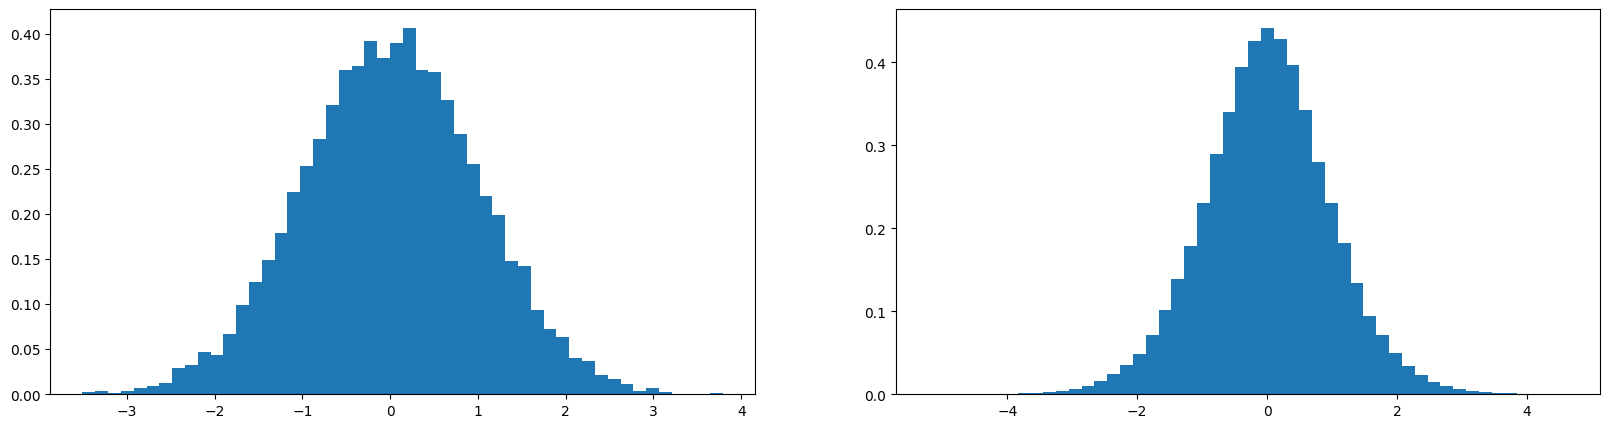

In [9]:
x = torch.randn(1000,10)
w = torch.randn(10, 200) / 10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

In [10]:
hpreact.mean(0, keepdim=True).shape

NameError: name 'hpreact' is not defined

In [11]:
hpreact.std(0, keepdim=True).shape

NameError: name 'hpreact' is not defined

In [137]:
#same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] #batch X,Y

    #forward pass
    emb = C[Xb] #embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) #concatenate the vectors
    #linear layer
    hpreact = embcat @ W1 #+ b1 #hidden layer pre-activation #
    #batchnorm layer
    #----------------------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    #----------------------------------------------------------------
    #non-linearity
    h = torch.tanh(hpreact) #hidden layer
    logits = h @ W2 + b2 #output layer
    loss = F.cross_entropy(logits, Yb) #loss function

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i < 100000 else 0.01 #step learning rate decay
    for p in parameters:
            p.data += -lr * p.grad

    #track stats
    if i % 10000 == 0: #print every once in a while
        print(f'{i:7d}/{max_steps: 7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3239


KeyboardInterrupt: 

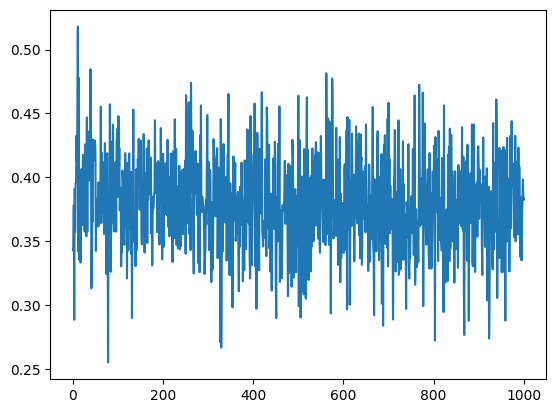

In [103]:
plt.plot(lossi)

In [15]:
#calibrate the batch norm at the end of training

#with torch.no_grad():
    ##pass the training set through
    #emb = C[Xtr]
    #embcat = emb.view(emb.shape[0], -1)
    #hpreact = embcat @ W1 + b1
    ##measure the mean/std over the entire training set
    #bnmean = hpreact.mean(0, keepdim=True)
    #bnstd = hpreact.std(0, keepdim=True)

In [117]:
@torch.no_grad() #this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] #(N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) #concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 #+ b1
    #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')
        

train 3.2939441204071045
val 3.293783187866211


#loss log

#original:
train 2.0582430362701416
val 2.0889034271240234

#fix softmax confidently wrong:
train 2.018712043762207
val 2.074272871017456

#fix tanh layer too saturated at init:
train 1.9931648969650269
val 2.05146861076355

#use semi-principled "kaiming init" instead of hacky init
train 1.993333339691162
val 2.050889253616333

#add a batch norm layer
train 2.023623466491699
val 2.0620474815368652

train 2.023623466491699
val 2.061993360519409

train 2.0232341289520264
val 2.0620813369750977

In [ ]:
#SUMMARY -------------------------------------------------

In [207]:
#Let's train a deeper network
#The classes we create here are the same API as nn.Module in PyTorch

#a class named Linear for creating a linear layer in a neural network.
class Linear:
    #initialize the linear layer with input size (fan_in), output size (fan_out), and an optional bias
    def __init__(self, fan_in, fan_out, bias=True): 
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5 #initialize weights with random values and scale them by fan-in's square root for better training stability
        self.bias = torch.zeros(fan_out) if bias else None #initialize bias as zeros if bias is True; otherwise, set it to None

    #a method to make the object callable like a function, accepting input x
    def __call__(self, x): 
        self.out = x @ self.weight #compute the output by performing a matrix multiplication of input x and weights
        if self.bias is not None: 
            self.out += self.bias #Add the bias to the output if bias is being used
        return self.out

    #a method to retrieve the parameters of the layer
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

#a class named BatchNormId for 1D batch normalization
class BatchNorm1d:

    #initialize the batch normalization layer with input dimension (dim), a small epislon (eps) for 
    #numerical stability, and a momentum factor for running stastics
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps #set the epsilon value to avoid division by zero during normalization
        self.momentum = momentum #set the momentum (i.e., technique used to accelerate convergence) for updating running statistics
        self.training = True #flag to indicate whether the layer is in training mode or evaluation mode
        #parameters (trained with backprop)
        self.gamma = torch.ones(dim) #initialize scale parameter (gamma) as ones, which will be learned during training
        self.beta = torch.zeros(dim) #initialize shift parameter (beta) as zeros, which will also be learning during training
        #buffers (trained witha running 'momentum update')
        self.running_mean = torch.zeros(dim) #initialize running mean as zeros, used during evaluation
        self.running_var = torch.ones(dim) #initialize, running variance as ones, used during evaluation
    
    #a method to perform the forward pass of batch normalization when the object
    #is called with input x
    def __call__(self, x):
        #calculate the forward pass
        if self.training: 
            xmean = x.mean(0, keepdim=True) #batch mean along the first dimension (across the batch), keeping the dimension for broadcasting
            xvar = x.var(0, keepdim=True) #batch variance along the first dimension (across the batch), also keep the dimension
        else: 
            xmean = self.running_mean #use the running mean calculated during training
            xvar = self.running_var #use the running variance calculated during training
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) #normalize the input x to have zero mean and unit variance, adding epsilon for numerical stability 
        self.out = self.gamma * xhat + self.beta #scale and shift the normalized input using learned parameters gamma and beta
        #update the buffers
        if self.training:
            with torch.no_grad(): #disable gradient tracking for the following operations
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean #update the running mean using a momentum update
                self.running_var * (1-self.momentum) * self.running_var + self.momentum * xvar #update the running variance using a momentum update
        return self.out

    #a method to retrieve the learnable parametesr of the batch normalization layer
    def parameters(self):
        return [self.gamma, self.beta]

#a class named Tanh for the hyperbolic tangent activation function 
class Tanh:
    #a method to compute the forward pass of the Tanh function
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    #a method to retrieve the learnable paramters of the Tanh activation layer
    def parameters(self):
        return [] #return an empty list, as the Tanh function has no learnable parameters (i.e., it does not have any weights or biases that are adjusted during the training process)

n_embd = 10 #the dimensionality of the character embedding vectors
n_hidden = 100 #the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) #for reproducibility

C = torch.randn((vocab_size, n_embd),             generator=g) #initialize the embedding matrix C with random values, where vocab_size is the number of tokens and n_mbd is the embedding dimension

#create a list of layers to be used in the neural network model
layers = [ 
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad(): #disable gradient tracking, as we don't want to update any parameters in this context
    #last layer: make less confident 
    layers[-1].gamma *= 0.1 #modify the last layer's gamma parameter to make its output less confident and reduce the scaling effect of the batch normalization in the last layer
    #layers[-1].weight *= 0.1
    #all other layers: apply gain
    for layer in layers[:-1]: #iterate through all layers except the last one to apply a gain to the weights
        if isinstance(layer, Linear):
            layer.weight *= 1.0 #5/3 #scale the weights of the linear layer by a factor of 1.0 (currently a no-op since it does not change the value of the weights)

parameters = [C] + [p for layer in layers for p in layer.parameters()] #create a list of parameters starting with the embedding matrix C, followed by all the parameters from each layer in the layers list
print(sum(p.nelement() for p in parameters)) #print number of parameters in total
for p in parameters:
    p.requires_grad = True #set requires_grad to True for each parameter in the parameters list, indicating that we want to compute grad
        

47024


In [208]:
#same optimization as last time
max_steps = 200000 #maximum number of optimization steps for training
batch_size = 32 #size of each batch of data to be used during training 
lossi = [] #list to keep track of the loss values at each step
ud = [] #list to store the log10 of the ratio of gradient standard deviation to parameter standard deviation, scaled by the learning rate 

for i in range(max_steps):
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g) #random indices for selecting a batch from the training data
    Xb, Yb = Xtr[ix], Ytr[ix], #batch X (batch of inputs), Y (batch of target labels) 

    #forward pass
    emb = C[Xb] #embed the characters into vectors
    x = emb.view(emb.shape[0], -1) #concatenate to reshape the embedded vactors into 2D tensor for further processing
    for layer in layers:
        x = layer(x) #x is updated with the output from each layer
    loss = F.cross_entropy(x, Yb) #loss function (i.e., the scalar value representing the error in predictions)

    #backward pass
    for layer in layers: 
        layer.out.retain_grad() #AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None #set the gradient of each parameter to None to avoid accumulation
    loss.backward() #compute the gradients for all parameters based on the loss

    #update
    lr = 0.1 if i < 100000 else 0.01 #step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad #apply gradient descent update rule

    #track stats
    if i % 10000 == 0: #print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():4f}')
    lossi.append(loss.log10().item()) #append the logarithm (base 10) of the loss to the lossi list for tracking
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters]) #append the log10 of the ratio of scaled gradient std to parameter std for each parameter

    if i >= 1000:
        break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.287031


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.78%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.56%
layer 8 (      Tanh): mean -0.00, std 0.65, saturated: 2.25%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.69%
layer 14 (      Tanh): mean +0.00, std 0.65, saturated: 1.88%


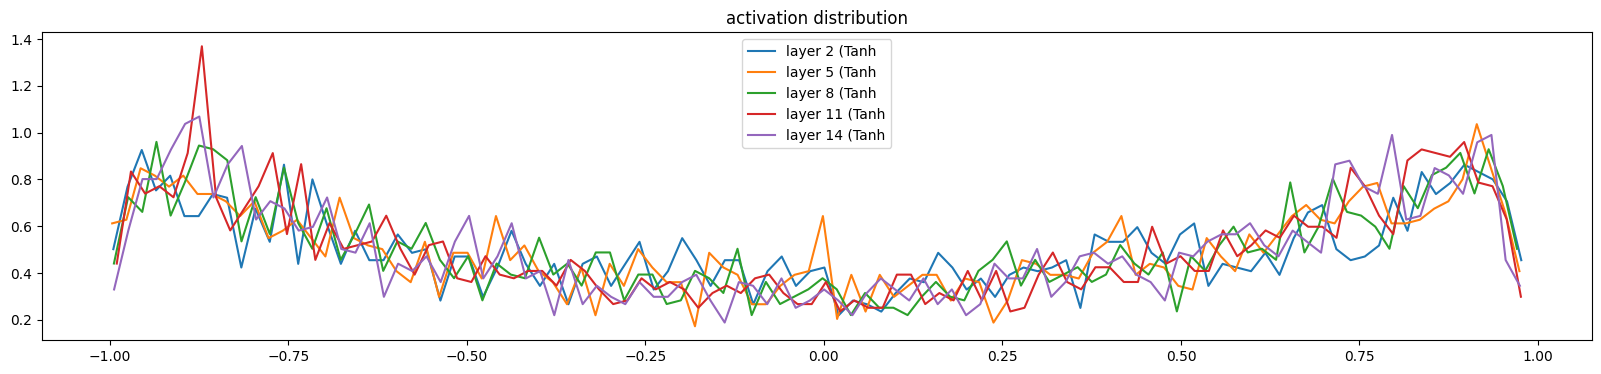

In [209]:
#visualize histograms
plt.figure(figsize=(20, 4)) #width and height of the plot
legends = [] #list to hold legends for the layers
for i, layer in enumerate(layers[:-1]): #note: exclude the output layer
    if isinstance(layer, Tanh): #check whether the current layer is an instance of the 'Tanh' activation function class
        t = layer.out #output activations from the layer
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100)) #print statistics about activations: mean, standard deviation, and percentage of values near saturation (|activation| > 0.97)
        hy, hx = torch.histogram(t, density=True) #normalized histogram of the activations
        plt.plot(hx[:-1].detach(), hy.detach()) #plot the histogram
        legends.append(f'layer {i} ({layer.__class__.__name__}') #add layer's label
    plt.legend(legends); #add the legends to the plot
    plt.title('activation distribution') #title for the plot

layer 2 (      Tanh): mean -0.000000, std 2.640702e-03
layer 5 (      Tanh): mean -0.000000, std 2.245584e-03
layer 8 (      Tanh): mean +0.000000, std 2.045742e-03
layer 11 (      Tanh): mean -0.000000, std 1.983134e-03
layer 14 (      Tanh): mean -0.000000, std 1.952382e-03


Text(0.5, 1.0, 'gradient distribution')

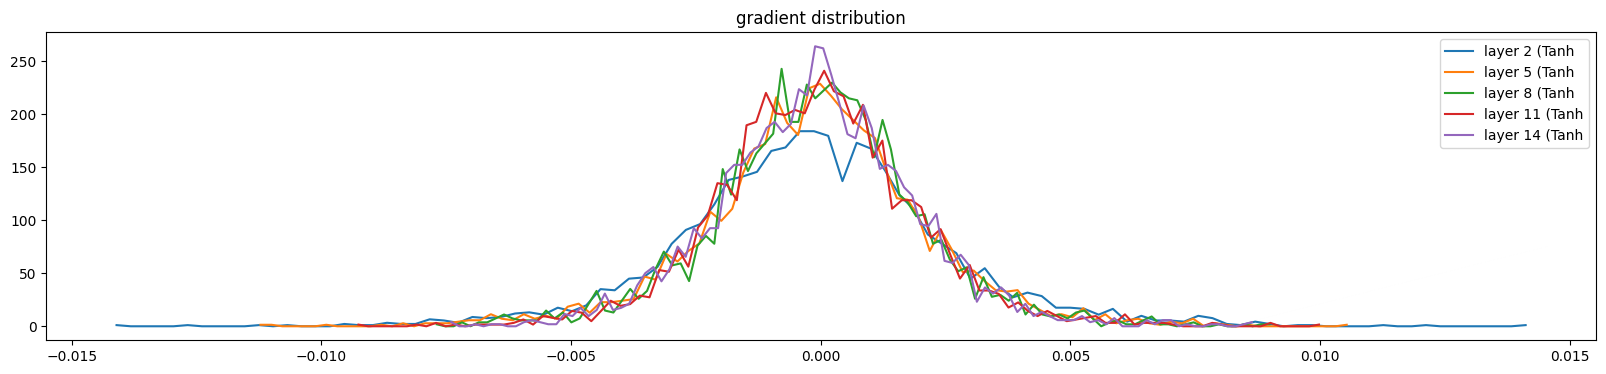

In [210]:
#visualize histogram
plt.figure(figsize=(20, 4)) #width and height of the plot
legends = [] #list to hold the legends for the layers
for i, layer in enumerate(layers[:-1]): #note: exclude the output layer
    if isinstance(layer, Tanh): #check whether the current layer is an instance of 'Tanh' activation function
        t = layer.out.grad #gradient of the output activations from the current  'Tanh' layer
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std())) #print statistics about the gradient: mean and standard deviation
        hy, hx = torch.histogram(t, density=True) #compute a normalized histogram of the gradients
        plt.plot(hx[:-1].detach(), hy.detach()) #plot the histogram
        legends.append(f'layer {i} ({layer.__class__.__name__}') #add the layer's label
plt.legend(legends); #add the legends
plt.title('gradient distribution') #set the title for the plot

weight   (27, 10) | mean -0.000000 | std 8.020533e-03 | grad: data ratio 8.012629e-03
weight  (30, 100) | mean +0.000246 | std 9.241072e-03 | grad: data ratio 4.881088e-02
weight (100, 100) | mean +0.000113 | std 7.132874e-03 | grad: data ratio 6.964615e-02
weight (100, 100) | mean -0.000086 | std 6.234300e-03 | grad: data ratio 6.073736e-02
weight (100, 100) | mean +0.000052 | std 5.742186e-03 | grad: data ratio 5.631481e-02
weight (100, 100) | mean +0.000032 | std 5.672204e-03 | grad: data ratio 5.570124e-02
weight  (100, 27) | mean -0.000082 | std 1.209416e-02 | grad: data ratio 1.160106e-01


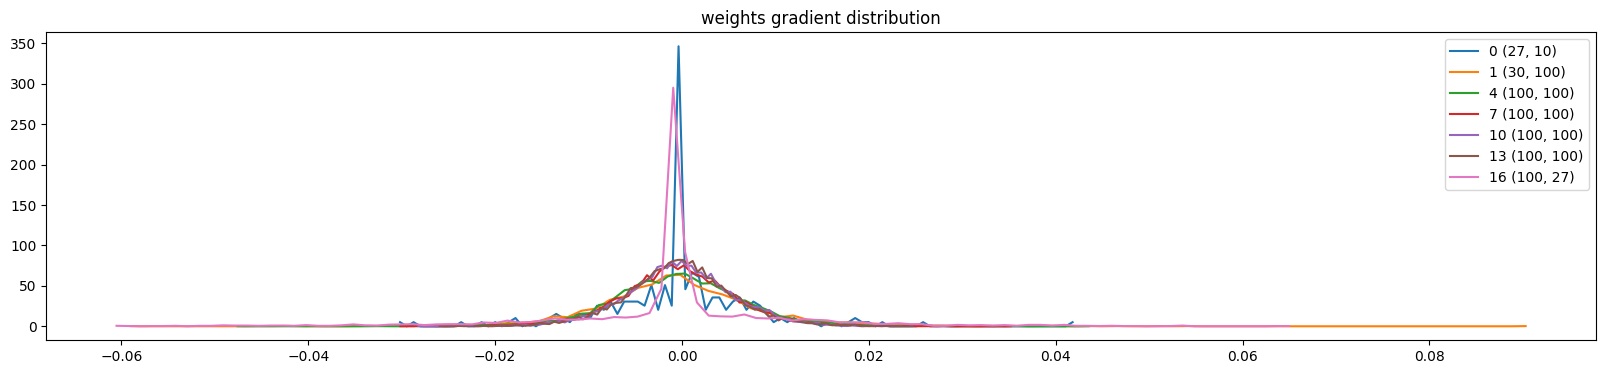

In [211]:
#visualize histograms
plt.figure(figsize=(20, 4)) #width and height of the plot
legends=[] #list to hold legends for the plot
for i,p in enumerate(parameters): #loop through all parameters such as weights and biases
    t = p.grad # gradient for the current parameter 'p' (assumed to be a tensor)
    if p.ndim == 2: #check whether the parameter is a 2D tensor (i.e., weights, as biases are ypically 1D)
        print('weight %10s | mean %+f | std %e | grad: data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True) #compute the normalized histogram
        plt.plot(hx[:-1].detach(), hy.detach()) #plot the histogram
        legends.append(f'{i} {tuple(p.shape)}') #add the label for the legend
    plt.legend(legends) #add a legend to the plot
    plt.title('weights gradient distribution'); #set the title of the plot

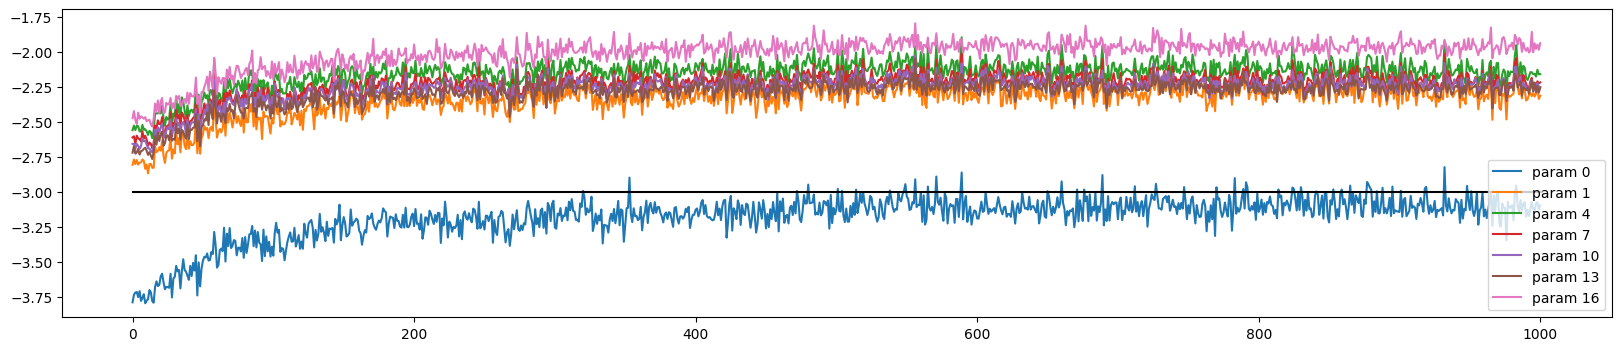

In [212]:
plt.figure(figsize=(20, 4))
legends = [] #list to hold the legend entries for the plot
for i,p in enumerate(parameters): #iterate over the parameters of the model, where 'parameters' is a list of model parameters
    if p.ndim == 2: #check whether the parameter is a 2D tensor (usually weights, as biases are typically 1D).
        plt.plot([ud[j][i] for j in range(len(ud))]) #plot the update (or ratio) for this parameter over time (assuming 'ud' is a list of updates)
        legends.append('param %d' % i) #add a legend entry indiating the index of parameter
plt.plot([0, len(ud)], [-3, -3], 'k') #these ratios should be ~1e-3, indicate on plat
plt.legend(legends); #add the legends to the plot, so each line is labeled with the corresponding parameter index

In [213]:
@torch.no_grad() # this decorator disables gradient tracking

#Method to select the appropriate data based on the value of 'splot'
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr), 
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] #use the input data 'x' to look up embeddings from the embedding matrix 'C'. embedding shape is (N, block_size, n_embd), where N is the batch size block_size is the sequence length, and n_embd is the embedding dimension
  x = emb.view(emb.shape[0], -1) # concat to flatten the embeddings to a single vector per input example. this transforms the embeddings from shape (N, block_size, n_embd) to (N, block_size * n_embd)
  for layer in layers: #apply the sequence of layers to the input tensor
    x = layer(x) #each layer operates on the output of the previous layer
  loss = F.cross_entropy(x, y) #compute the cross-entropy loss between the predicted output 'x' and the true labels 'y'
  print(split, loss.item()) #print the loss value for the current split (train, val or test)

# put layers into eval mode
for layer in layers:
  layer.training = False #disable training mode for layers (i.e.,  turn off dropout, batch normalization updates, etc)
split_loss('train') #compute and print the loss for the training split
split_loss('val') #compute and print the loss for the validation split

train 2.674372911453247
val 2.6655080318450928


In [214]:
#sample from the model
g = torch.Generator().manual_seed(2147483647 + 10) #for reproducibility

for _ in range(20): #generate 20 different sequences of sames (20 iterations in total)
    out = [] #list to store the generated tokens
    context = [0] * block_size #initialize with all ...
    while True:
        #forward pass the neural net
        emb = C[torch.tensor([context])] #embeddings for the current context with shape (1,block_size,n_embd)
        x = emb.view(emb.shape[0], -1) #flatten the embeddings into a 2D tensor (N, block_size * n_embd)
        for layer in layers: #pass the tensor through the network layers
            x = layer(x) #each layer modifies 'x' and passes it to the next layer
        logits = x #get the final output (logits) from the last layer
        probs = F.softmax(logits, dim=1) #apply the softmax function to get probabilities over the token space
        #sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item() #sample a token index from the probability distribution
        #shift the context window and track the samples
        context = context[1:] + [ix] #update the context: remove the first token and append the newly sampled token
        out.append(ix) #append the sampled token index to the output list
        #if we sample the special '.' token, break
        if ix == 0: #if the special token with index 0 is sampled, break the loop
            break

    print(''.join(itos[i] for i in out)) #decode and print the generated word
    

carpa.
xqarlil.
kakimrix.
thty.
sacans.
ejanh.
enf.
pnrah.
iarqeiu.
elani.
tceniiv.
arle.
yph.
ama.
ora.
qenja.
sron.
ean.
adbq.
wan.
